# TCSS 588 BioInformatics Project: Identifying key genes in AML
## Siri Sadashiva

### README
#### The below cell installs all the required dependencies required to run for this notebook. If the installation fails, please install the following by running the commands in the terminal:

### Scikit
1. conda install scikit-learn (OR)
2. pip install -U scikit-learn

---------------------------------------------------------------------------------------------------------------------
### Matplotlib
1. conda install -c conda-forge matplotlib (OR)
2. pip install --upgrade setuptools 
   pip install matplotlib

---------------------------------------------------------------------------------------------------------------------


In [61]:
%matplotlib inline
!pip install --user scikit-learn

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from clean import assay_transpose
from clean import manifest_clinical_merge
from clean import assay_clinical_merge
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc


# I. Data Preprocessing
### Please make sure to run the pd.read_csv command by specififying the correct directory that contains the csv file 

In [47]:
pd.options.mode.chained_assignment = None
manifest_df = pd.read_csv('../BioInformatics_Project/Manifest_Data/GCD_TARGET_Data_Manifest_AML_NBL_WT_RT.csv')
aml_disc_df = pd.read_excel('../BioInformatics_Project/Clinical_Data/TARGET_AML_ClinicalData_20160714.xlsx')
AML_df = manifest_clinical_merge(manifest_df, aml_disc_df, 'TARGET-AML')
assay_df = pd.read_csv('../BioInformatics_Project/Expn_Data/TARGET_NBL_AML_RT_WT_TMMCPM_log2_Norm_Counts.csv.zip')
assay_t_df = assay_transpose(assay_df)
AML_genes = assay_clinical_merge(assay_t_df, AML_df)

In [49]:
df1 = AML_genes[AML_genes['Diagnostic ID'].isin(('09A', '03A', '01A'))]
df2 = df1[df1['Risk group'] != 'Unknown'].copy()
df2['Risk_Group'] = df2['Risk group'].apply(lambda x: (x == 'Low') * 1)


In [50]:
data = df2.iloc[:,:-1]
X = data.iloc[:,84:-4]
X = X.apply(pd.to_numeric)
y = df2.loc[data.index, 'Risk_Group']

In [51]:
X.shape

(137, 21403)

In [52]:
y.value_counts()

0    77
1    60
Name: Risk_Group, dtype: int64

#### Total count of:  Risk_Group 'Low' = 60;  Risk_Group 'High' = 77

# II. Feature Selection: Correlation
### Calculating correlation coefficients for all the genes

In [54]:
correlation_matrix = X.corr()

In [55]:
#Get highly correlated co-efficients
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.80)]

#drop highly correlated coefficients 
for i in to_drop:
    del X[i]
    
X.shape

(137, 16841)

### After feature selection, we have 16841 genes out of 21403 genes

# III. Modeling

### Split the data into test and train sets 

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=8)

### Method: Random Forest Classification

In [57]:
#Initialize K-Fold: k = 10
kf = KFold(n_splits=10,shuffle=True)

#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=80)

#Initialize predictions
predictions =[]

#Run 10 times
for k, (train, test) in enumerate(kf.split(X, y)):
    #Fit and train the model
    clf.fit(X_train,y_train)
    
    #Get the prediction
    predictions.append(clf.score(X_test, y_test))

### Calculate Metrics

Accuracy of the Random Forest Classifier is 
0.928571428571
------------------------------------------------
Confusion Matrix:
[[18  1]
 [ 1  8]]
------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95        19
          1       0.89      0.89      0.89         9

avg / total       0.93      0.93      0.93        28

------------------------------------------------


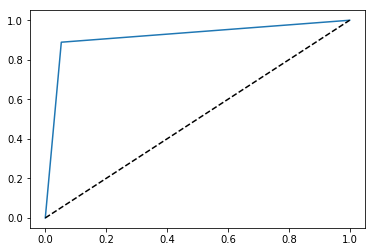

Area under curve (AUC):  0.918128654971


In [58]:
#Accuracy 
print("Accuracy of the Random Forest Classifier is ")
print(sum(predictions) / float(len(predictions)))
print("------------------------------------------------")

#Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Classification Report
print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Area Under Curve 
y_score = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))


### Feature Importance: Top 10 Genes

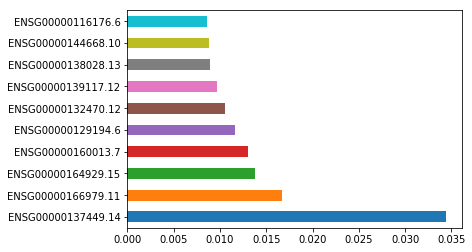

In [59]:
(pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')) 

In [60]:
#pd.set_option('display.max_columns', None)